In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import random
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
import statistics
from sklearn import preprocessing
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
ticker = "TNA"

In [3]:
def getDB(ticker):
    tick = ticker
    # Load data
    data = yf.Ticker(tick)
    df = data.history(period="5y", interval="1d")
#     df = data.history(start="2018-12-01", end="2020-03-01")
#     start="2017-01-01", end="2017-04-30"
    
    # add data points
    df['close_per1'] = df.ta.percent_return(1)*100
    df['sma10'] = df.ta.sma(length=10)
    df['williams'] = df.ta.willr()


    df = df[[
            'open','close','sma10','williams','close_per1'
            ]]

    df = df.dropna()
    
    return df

In [4]:
data = getDB(ticker)
print(data['close_per1'].std())
print(data.head(15))
print(data.tail(15))

4.448871370564073
                 open      close      sma10   williams  close_per1
date                                                              
2017-01-20  49.030236  49.208237  50.167484 -76.465377    1.478528
2017-01-23  48.812673  48.649502  49.949428 -85.270668   -1.135450
2017-01-24  49.163738  50.775665  50.048319 -47.116217    4.370371
2017-01-25  52.031586  52.328259  50.155616 -16.128967    3.057751
2017-01-26  52.348033  51.715126  50.177867 -19.549763   -1.171704
2017-01-27  51.764582  51.111900  50.261431 -32.036748   -1.166440
2017-01-30  50.043873  49.079685  50.032003 -74.028611   -3.976012
2017-01-31  48.535789  49.989487  50.109634 -55.214640    1.853723
2017-02-01  51.097063  49.999374  50.134851 -55.010170    0.019780
2017-02-02  50.103211  49.475250  50.233249 -65.848640   -1.048261
2017-02-03  50.810277  51.720074  50.484432 -19.427478    4.537265
2017-02-06  51.240454  50.587772  50.678259 -42.842568   -2.189288
2017-02-07  50.661942  49.959816  50.596674 

In [5]:
def set_data(ticker):
    df = getDB(ticker)

    df['CP_ol'] = 0
    df['CO_il'] = 0
    df['SMA10_il'] = 0
    df['W_il'] = 0
    
    value = df['close_per1'].std()
    
    # setting the outputs in the df
    for i in range(len(df)):
        if df.iloc[i]['close_per1'] > value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 2
        elif df.iloc[i]['close_per1'] < -value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 1
        else:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 0
    
    # setting the inputs in the df
    for i in range(len(df)-1):
        try:
            if df.iloc[i]['close'] < df.iloc[i+1]['open']:
                df.iloc[i+1, df.columns.get_loc('CO_il')] = 1
            else:
                df.iloc[i+1, df.columns.get_loc('CO_il')] = 0
        except:
            df.iloc[i+1, df.columns.get_loc('CO_il')] = np.nan
            
    
    # setting the inputs in the df
    for i in range(len(df)):
        try:
            if df.iloc[i]['close'] > df.iloc[i]['sma10']:
                df.iloc[i, df.columns.get_loc('SMA10_il')] = 1
            else:
                df.iloc[i, df.columns.get_loc('SMA10_il')] = 0
        except:
            df.iloc[i, df.columns.get_loc('SMA10_il')] = np.nan
            
    
    # setting the inputs in the df
    for i in range(len(df)):
        if df.iloc[i]['williams'] > -30: # overbought
            df.iloc[i, df.columns.get_loc('W_il')] = -1
        elif df.iloc[i]['williams'] < -70: # oversold
            df.iloc[i, df.columns.get_loc('W_il')] = 1
        else:
            df.iloc[i, df.columns.get_loc('W_il')] = 0 # neutral
    
    
    # deleting data that is not normalized
    del df['open']
    del df['close']
    del df['sma10']
    del df['williams']
#     del df['close_per1']
    
    # reformating
    df = df[[
            'W_il','SMA10_il','CO_il','CP_ol','close_per1'
            ]]
    
    return df

In [6]:
df = set_data(ticker)
print(data.head())
print(data.tail())

                 open      close      sma10   williams  close_per1
date                                                              
2017-01-20  49.030236  49.208237  50.167484 -76.465377    1.478528
2017-01-23  48.812673  48.649502  49.949428 -85.270668   -1.135450
2017-01-24  49.163738  50.775665  50.048319 -47.116217    4.370371
2017-01-25  52.031586  52.328259  50.155616 -16.128967    3.057751
2017-01-26  52.348033  51.715126  50.177867 -19.549763   -1.171704
                 open      close      sma10   williams  close_per1
date                                                              
2021-12-23  83.099998  84.199997  78.760229 -26.619072    2.395711
2021-12-27  84.500000  86.599998  79.254777 -14.188268    2.850358
2021-12-28  86.199997  85.029999  79.934092 -22.320079   -1.812933
2021-12-29  84.889999  85.260002  80.845266 -17.004946    0.270497
2021-12-30  85.180000  87.417297  81.603419  -5.247014    2.530255


In [7]:
def process_train(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[0:-SHIFT]
        
        del df['close_per1']
        
        df.head()

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")



In [8]:
def process_test(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]
        
        del df['close_per1']
        df.head()

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")

In [9]:
SEQ_LEN = 2  # how long of a preceeding sequence to collect for RNN
# FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
SHIFT = 150  # how far to shift the data so it can be back testest
BATCH_SIZE = 64 # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
EPOCHS = 500 # how many passes through our data


tickers_train = [ticker]
tickers_test = [ticker]

train_x, train_y = process_train(tickers_train, SEQ_LEN,SHIFT)
validation_x, validation_y = process_test(tickers_test, SEQ_LEN, SHIFT)

In [10]:
print(train_x[0])
print('training data length: %d' % (len(train_x)))
print('validation data length: %d' % (len(validation_x)))

[[ 0.  1.  1.]
 [-1.  1.  1.]]
training data length: 315
validation data length: 42


In [11]:
## Building the RNN ##
print()
print("length of train data: ", len(train_x))
print("length of validation data: ", len(validation_x))
print()

model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1:]), activation='tanh', return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(64, activation='tanh'))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(64, activation='tanh'))
# model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.000015, decay=1e-6)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)
)

print()
print()

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()


length of train data:  315
length of validation data:  42

Epoch 1/500
5/5 [==============================] - 3s 158ms/step - loss: 1.6161 - accuracy: 0.2571 - val_loss: 1.0989 - val_accuracy: 0.2857
Epoch 2/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5932 - accuracy: 0.2540 - val_loss: 1.0988 - val_accuracy: 0.3095
Epoch 3/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5795 - accuracy: 0.2508 - val_loss: 1.0987 - val_accuracy: 0.3095
Epoch 4/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5406 - accuracy: 0.2635 - val_loss: 1.0987 - val_accuracy: 0.3095
Epoch 5/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5274 - accuracy: 0.2857 - val_loss: 1.0986 - val_accuracy: 0.3095
Epoch 6/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4943 - accuracy: 0.2730 - val_loss: 1.0985 - val_accuracy: 0.2857
Epoch 7/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4849 - accuracy: 0.2984 - val_l

5/5 [==============================] - 0s 11ms/step - loss: 1.0289 - accuracy: 0.4762 - val_loss: 1.0771 - val_accuracy: 0.4286
Epoch 60/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0217 - accuracy: 0.5206 - val_loss: 1.0763 - val_accuracy: 0.4286
Epoch 61/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0213 - accuracy: 0.4889 - val_loss: 1.0755 - val_accuracy: 0.4286
Epoch 62/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0190 - accuracy: 0.4921 - val_loss: 1.0747 - val_accuracy: 0.4286
Epoch 63/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0165 - accuracy: 0.4952 - val_loss: 1.0738 - val_accuracy: 0.4286
Epoch 64/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0138 - accuracy: 0.5143 - val_loss: 1.0730 - val_accuracy: 0.4286
Epoch 65/500
5/5 [==============================] - 0s 8ms/step - loss: 1.0137 - accuracy: 0.5111 - val_loss: 1.0721 - val_accuracy: 0.4286
Epoch 66/500
5/5 [==============

5/5 [==============================] - 0s 7ms/step - loss: 0.9490 - accuracy: 0.5556 - val_loss: 1.0093 - val_accuracy: 0.5000
Epoch 118/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9455 - accuracy: 0.5524 - val_loss: 1.0077 - val_accuracy: 0.5000
Epoch 119/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9460 - accuracy: 0.5460 - val_loss: 1.0062 - val_accuracy: 0.5714
Epoch 120/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9467 - accuracy: 0.5587 - val_loss: 1.0048 - val_accuracy: 0.5714
Epoch 121/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9442 - accuracy: 0.5619 - val_loss: 1.0033 - val_accuracy: 0.5714
Epoch 122/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9417 - accuracy: 0.5587 - val_loss: 1.0018 - val_accuracy: 0.5714
Epoch 123/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9420 - accuracy: 0.5841 - val_loss: 1.0001 - val_accuracy: 0.5714
Epoch 124/500
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.9046 - accuracy: 0.5873 - val_loss: 0.9310 - val_accuracy: 0.6667
Epoch 176/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8958 - accuracy: 0.6095 - val_loss: 0.9299 - val_accuracy: 0.6667
Epoch 177/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8952 - accuracy: 0.5937 - val_loss: 0.9289 - val_accuracy: 0.6667
Epoch 178/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8898 - accuracy: 0.6032 - val_loss: 0.9281 - val_accuracy: 0.6667
Epoch 179/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8895 - accuracy: 0.6000 - val_loss: 0.9272 - val_accuracy: 0.6667
Epoch 180/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8856 - accuracy: 0.6000 - val_loss: 0.9261 - val_accuracy: 0.6667
Epoch 181/500
5/5 [==============================] - 0s 8ms/step - loss: 0.9084 - accuracy: 0.6032 - val_loss: 0.9251 - val_accuracy: 0.6667
Epoch 182/500
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.8393 - accuracy: 0.6159 - val_loss: 0.8812 - val_accuracy: 0.7143
Epoch 234/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8492 - accuracy: 0.6444 - val_loss: 0.8804 - val_accuracy: 0.7143
Epoch 235/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8492 - accuracy: 0.6095 - val_loss: 0.8795 - val_accuracy: 0.7143
Epoch 236/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8404 - accuracy: 0.6317 - val_loss: 0.8786 - val_accuracy: 0.7143
Epoch 237/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8491 - accuracy: 0.6222 - val_loss: 0.8778 - val_accuracy: 0.7143
Epoch 238/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8510 - accuracy: 0.6286 - val_loss: 0.8772 - val_accuracy: 0.7143
Epoch 239/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8479 - accuracy: 0.6159 - val_loss: 0.8764 - val_accuracy: 0.7143
Epoch 240/500
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.8016 - accuracy: 0.6413 - val_loss: 0.8400 - val_accuracy: 0.6667
Epoch 292/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8074 - accuracy: 0.6190 - val_loss: 0.8394 - val_accuracy: 0.6667
Epoch 293/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8026 - accuracy: 0.6317 - val_loss: 0.8387 - val_accuracy: 0.6667
Epoch 294/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8059 - accuracy: 0.6286 - val_loss: 0.8384 - val_accuracy: 0.6667
Epoch 295/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7975 - accuracy: 0.6476 - val_loss: 0.8381 - val_accuracy: 0.6667
Epoch 296/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8098 - accuracy: 0.6381 - val_loss: 0.8374 - val_accuracy: 0.6667
Epoch 297/500
5/5 [==============================] - 0s 8ms/step - loss: 0.8071 - accuracy: 0.6349 - val_loss: 0.8366 - val_accuracy: 0.6667
Epoch 298/500
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.7685 - accuracy: 0.6571 - val_loss: 0.8080 - val_accuracy: 0.6429
Epoch 350/500
5/5 [==============================] - 0s 10ms/step - loss: 0.7790 - accuracy: 0.6540 - val_loss: 0.8076 - val_accuracy: 0.6429
Epoch 351/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7701 - accuracy: 0.6476 - val_loss: 0.8071 - val_accuracy: 0.6429
Epoch 352/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7627 - accuracy: 0.6508 - val_loss: 0.8067 - val_accuracy: 0.5714
Epoch 353/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7639 - accuracy: 0.6571 - val_loss: 0.8061 - val_accuracy: 0.5714
Epoch 354/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7668 - accuracy: 0.6476 - val_loss: 0.8056 - val_accuracy: 0.5714
Epoch 355/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7640 - accuracy: 0.6571 - val_loss: 0.8051 - val_accuracy: 0.5714
Epoch 356/500
5/5 [=======

5/5 [==============================] - 0s 8ms/step - loss: 0.7515 - accuracy: 0.6698 - val_loss: 0.7825 - val_accuracy: 0.5714
Epoch 408/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7379 - accuracy: 0.6635 - val_loss: 0.7820 - val_accuracy: 0.5714
Epoch 409/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7474 - accuracy: 0.6476 - val_loss: 0.7817 - val_accuracy: 0.5714
Epoch 410/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7401 - accuracy: 0.6603 - val_loss: 0.7817 - val_accuracy: 0.5714
Epoch 411/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7445 - accuracy: 0.6540 - val_loss: 0.7813 - val_accuracy: 0.5714
Epoch 412/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7390 - accuracy: 0.6571 - val_loss: 0.7812 - val_accuracy: 0.5714
Epoch 413/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7404 - accuracy: 0.6571 - val_loss: 0.7805 - val_accuracy: 0.5714
Epoch 414/500
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.7312 - accuracy: 0.6571 - val_loss: 0.7641 - val_accuracy: 0.5952
Epoch 466/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7174 - accuracy: 0.6698 - val_loss: 0.7637 - val_accuracy: 0.5952
Epoch 467/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7298 - accuracy: 0.6730 - val_loss: 0.7633 - val_accuracy: 0.5952
Epoch 468/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7243 - accuracy: 0.6635 - val_loss: 0.7633 - val_accuracy: 0.5952
Epoch 469/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7247 - accuracy: 0.6794 - val_loss: 0.7628 - val_accuracy: 0.5952
Epoch 470/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7338 - accuracy: 0.6667 - val_loss: 0.7627 - val_accuracy: 0.5952
Epoch 471/500
5/5 [==============================] - 0s 8ms/step - loss: 0.7311 - accuracy: 0.6571 - val_loss: 0.7623 - val_accuracy: 0.5952
Epoch 472/500
5/5 [========

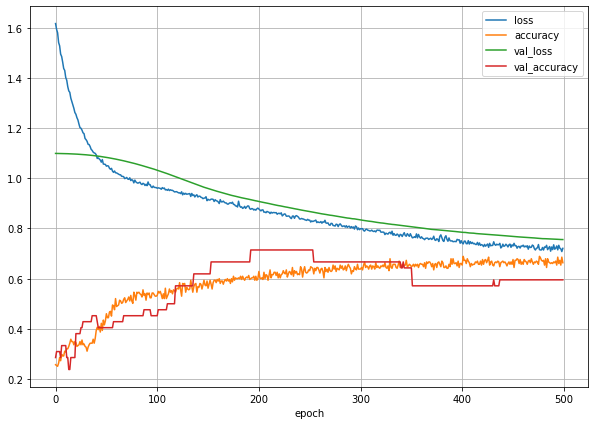

Test loss: 0.7557585835456848
Test accuracy: 0.5952380895614624


In [12]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('epoch')
plt.grid()
plt.show()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [13]:
def process_test_buys(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!
        
        Sequential_data = Sequential_data + sequential_data
        
    X = []; y = []; z = []
    for seq, target, actual in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        z.append(actual)

    return np.array(X).astype("float64"), np.array(y).astype("uint8"), np.array(z).astype("float64")

In [14]:
df = set_data(ticker)

sequential_data = []  # this is a list that will CONTAIN the sequences
prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

for i in df.values:  # iterate over the values
    prev_days.append([n for n in i[:-2]])  # store all but the target
    if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
        sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!

        
buy = []; notbuy = []; maybe = []

for seq, target, actual in sequential_data:  # iterate over the sequential data
    if target == 0:
        maybe.append([seq, target, actual])
    elif target == 1:
        notbuy.append([seq, target, actual]) 
    elif target == 2:
        buy.append([seq, target, actual])  
        

In [15]:
last_trading_days = 100
test_x, test_y, test_z = process_test_buys(tickers_test, SEQ_LEN, last_trading_days)

In [16]:
output = model.predict(test_x)

In [22]:
results = []; total = 0
for i, j in zip(output, test_z):
    if np.argmax(i) == 2:
        total += 1
#         results.append([i,j])
        results.append(j)

In [23]:
print('Trading period: %d percent, over %d trades.' % (np.sum(results)/len(results), len(results)))
print('Average daily return: %d percent, over %d trades.' % (np.sum(results)/len(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period: 2 percent, over 34 trades.
Average daily return: 2 percent, over 34 trades.
You started with $5000 and finished with $11174 after 34 trades.


In [24]:
print(results)

[1.4082912116520685, -0.772769021589037, 5.025056559514063, 5.726489588815231, 2.945719141125891, 8.35394753164409, -1.2505481437498966, 2.017374950722206, 0.6445998637189643, 4.458672335756675, 5.388521343106012, 4.3221755332707, 4.776841940851462, 4.736963722489929, 1.7171922475946566, 4.332835651170441, -0.9142991318043636, 1.9584132644258512, -2.2327137641667827, 6.005465774391272, 0.657241209325643, 4.243112701059504, 0.9386188953442121, 2.4476563509958416, 0.23331953432994545, -1.2791909238900834, -0.6247845791248041, -6.820156418592194, 6.840351822165136, -0.8734705143035981, 4.842526804934022, 8.627715496969547, 2.3957114324287376, 2.850358210053372]


In [25]:
results = []; total = 0
for i, j in zip(output, test_z):
    if i[2] > 0.6:
        total += 1
#         results.append([i,j])
        results.append(j)

In [26]:
print('Trading period: %d percent, over %d trades.' % (np.sum(results)/len(results), len(results)))
print('Average daily return: %d percent, over %d trades.' % (np.sum(results)/len(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period: 5 percent, over 12 trades.
Average daily return: 5 percent, over 12 trades.
You started with $5000 and finished with $9015 after 12 trades.


In [27]:
print(results)

[5.025056559514063, 5.726489588815231, 2.945719141125891, 4.458672335756675, 5.388521343106012, 4.776841940851462, 4.736963722489929, 1.7171922475946566, 4.332835651170441, 6.005465774391272, 6.840351822165136, 8.627715496969547]
